# CLAUDIO RICCI

## Packages

In [1]:
import networkx as nx # For graphs
import pickle # For data parsing
from networkx.algorithms.approximation import greedy_tsp # For approx TSP
import numpy as np

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

import warnings
from timeit import default_timer as timer
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Helper functions

In [2]:
def tour_length(G, tour):
    """
    Compute the length of a tour. A tour is a list having elments 0 and -1 equal
    """
    assert tour[0] == tour[-1], "Not valid tour"
    estimated = 0
    n = G.number_of_nodes()
    for i in range(n):
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G):
    """
    Run the value of the greedy approximation algorithm on graph G
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G, seed = 42):
    """
    Return the value of a random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour_length(G, tour)

def transformer_tsp(G, model, DEVICE = 'cpu'):
    """
    Evaluate your (trained) model on G
    """
    # Set the model in evaluation mode
    
    model.eval()

    # Note: number of edges is constant ed equal to n(n-1)/2
    n = G.number_of_nodes()
    
    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))

    # From list of tensors to tensor 2d
    x = torch.stack(x)    

    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)

    with torch.no_grad():
    
        _, tgt_mask, _, _ = create_mask(x, y, DEVICE)
        
        out = model(x, y, None, tgt_mask, None, None)
        
        # Loop until the tour is complete
        while len(tour) < n:
            _, idx = torch.topk(out, n, dim=2)
            for i in range(n):
                # Check if the node is already in the tour
                if idx[0, 0, i] not in tour:
                    tour.append(idx[0, 0, i])
                    break
            y = torch.tensor(tour)
            y = y.to(DEVICE).unsqueeze(0)
    
            tgt_seq_len = y.shape[1]
    
            tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
            
            out = model(x, y, None, tgt_mask, None, None)
            # out = model(x, y)
    
    tour = [int(i) for i in tour] + [0] # Append the starting node (that is hard-coded to 0)
    
    return tour_length(G, tour)

def gap(G, model = None, model_GA = None, random_seed = 42, device = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    """
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight']*G[i][j]['tour'] for (i, j) in G.edges()]) # Optimal

    # Gaps dictionary
    gaps = {'greedy' : 0, 'random' : 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100* (greedy_algorithm(G) -  TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf') # In case you just train with GA
        
    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf') # In case you just train without GA
        
    return gaps

## Dataset & Dataloader

Load the dummy dataset, get a single data item and explain its Python type

In [3]:
with open('/kaggle/input/tspinstances/dummy_20_DLL_ass4.pkl', 'rb') as file:
    dummy = pickle.load(file)

print(type(dummy)) # list
print('Type of a element of the dataset: ', type(dummy[0]))  # The type of the first object -> tuple
print('Type of the first item of the tuple: ', type(dummy[0][0]))  # The type of the first item of a tuple -> Graph
print('Type of the second item of the tuple: ', type(dummy[0][1]))  # The type of the first item of a tuple -> list
print(dummy[0])

<class 'list'>
Type of a element of the dataset:  <class 'tuple'>
Type of the first item of the tuple:  <class 'networkx.classes.graph.Graph'>
Type of the second item of the tuple:  <class 'list'>
(<networkx.classes.graph.Graph object at 0x7b864c9a14b0>, [0, 3, 14, 2, 9, 6, 19, 13, 12, 16, 7, 18, 8, 17, 5, 11, 10, 15, 1, 4, 0])


Describe the edge attributes: `tour` and `weight`

In [5]:
# Extract the graph and tour
graph = dummy[0][0]  # The networkx Graph object
tour = dummy[0][1]   # The tour as a list of nodes

# Inspect edges with attributes
print("Edges and attributes:")
for i, (u, v, data) in enumerate(graph.edges(data=True)):
    if i >= 5:
        break
    print(f"  Edge ({u}, {v}):")
    print('     Weight: ', {data.get('weight', 'Not found')})
    print('     Tour: ',{data.get('tour', 'Not found')})

Edges and attributes:
  Edge (0, 1):
     Weight:  {0.4287846201876535}
     Tour:  {0}
  Edge (0, 2):
     Weight:  {0.20417626260418414}
     Tour:  {0}
  Edge (0, 3):
     Weight:  {0.08154537102129383}
     Tour:  {1}
  Edge (0, 4):
     Weight:  {0.08031174728403137}
     Tour:  {1}
  Edge (0, 5):
     Weight:  {0.5612080164024046}
     Tour:  {0}


Inspect the node attribute `pos`

In [6]:
print("\nNodes and attributes:")
for node, data in graph.nodes(data=True):
    print(f"  Node {node}:")
    print('     Position: ',{data.get('pos', 'Not found')})


Nodes and attributes:
  Node 0:
     Position:  {(0.6049077053425551, 0.5748590937018008)}
  Node 1:
     Position:  {(0.38474987528197846, 0.9428085200806016)}
  Node 2:
     Position:  {(0.6102491981278754, 0.3707527129445174)}
  Node 3:
     Position:  {(0.5497610140601452, 0.514788385568776)}
  Node 4:
     Position:  {(0.5941533303116413, 0.6544475361385552)}
  Node 5:
     Position:  {(0.06187381797691738, 0.433195284467101)}
  Node 6:
     Position:  {(0.7475717305758963, 0.3950876312718402)}
  Node 7:
     Position:  {(0.6548530739834322, 0.06254140180263457)}
  Node 8:
     Position:  {(0.2210796367473482, 0.2142238067774731)}
  Node 9:
     Position:  {(0.6696714621150585, 0.4364218673039507)}
  Node 10:
     Position:  {(0.3206284506117195, 0.7885615893113229)}
  Node 11:
     Position:  {(0.37760295594024584, 0.4963855605324464)}
  Node 12:
     Position:  {(0.8300002368321365, 0.3489482457969727)}
  Node 13:
     Position:  {(0.9983722301898076, 0.2725163812162502)}
  Nod

In [ ]:
# Analyze the tour
# print("\nTour edges:")
# tour_edges = [(tour[i], tour[i+1]) for i in range(len(tour) - 1)]
# for u, v in tour_edges:
#     if graph.has_edge(u, v):
#         print(f"   Edge ({u}, {v}) exists with weight {graph[u][v].get('weight', 'Not found')}.")
#     else:
#         print(f"   Edge ({u}, {v}) does not exist in the graph.")

In [4]:
# Set seed 
torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [5]:
# Implement a dataset class. Focus on the getitem method to return:
# – X: A tensor of node coordinates with size 20 × 2.
# – y: A tour starting from 0 and ending with 0.

class GraphDataset(Dataset):
    def __init__(self, data):
        """
        A list of tuples where each tuple contains:
        - A networkx.Graph object
        - A tour (list of node indices)
        """
        self.data = data

    def __len__(self):
        """
        Number of instances in the dataset
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
        - X: A tensor of node coordinates with size 20 × 2.
        - y: A tensor representing the tour, starting and ending at 0.
        """
        # Extract the graph and tour
        graph, tour = self.data[idx]

        # Get node positions as a 2D array
        pos = nx.get_node_attributes(graph, 'pos')  # Dictionary {node: (x, y)}
        if not pos:
            raise ValueError(f"Graph at index {idx} is missing node positions ('pos').")

        # Ensure nodes are sorted by their index (important for consistent tensor order)
        sorted_positions = [pos[node] for node in sorted(graph.nodes())]
        
        # Convert positions to a tensor of shape (20, 2)
        X = torch.tensor(sorted_positions, dtype=torch.float32)

        # Convert the tour to a tensor
        y = torch.tensor(tour, dtype=torch.long)

        return X, y

In [10]:
# Dummy
# Create Dataset objects for training, validation, and testing, along with their respective Dataloader
# dataset = GraphDataset(dummy)
# train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

# batch_size = 32

# trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
with open('/kaggle/input/tspinstances/train_20_DLL_ass4.pkl', 'rb') as file:
    train = pickle.load(file)

with open('/kaggle/input/tspinstances/test_20_DLL_ass4.pkl', 'rb') as file:
    test = pickle.load(file)

with open('/kaggle/input/tspinstances/valid_20_DLL_ass4.pkl', 'rb') as file:
    valid = pickle.load(file)

batch_size = 32

train_dataset = GraphDataset(train)
val_dataset = GraphDataset(valid)
test_dataset = GraphDataset(test)

trainloader = DataLoader(train_dataset, batch_size=batch_size)
valloader = DataLoader(val_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self,emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        pos_embedding = torch.zeros((maxlen, emb_size))
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)   
        
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# n = 20
# n_enc = 4
# n_dec = 4
# de = 32
# dd = 32
# N_HEAD = 8
# DROPOUT = 0.1

class TSPTransformer(nn.Module):
    def __init__(self, n, num_encoder, num_decoder, de, dd, n_head, dropout, dim_feedforward=1024):
        super().__init__()
        # Encoder
        self.linear1 = nn.Linear(2, de)
        encoder_layer = nn.TransformerEncoderLayer(d_model=de, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True) # d_model (int) – the number of expected features in the input (required).
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder) # stack of n encoder layers
        self.linear2 = nn.Linear(de, dd)
        
        # Decoder
        self.embedding = nn.Embedding(n, dd)
        self.posEncoding = PositionalEncoding(dd, dropout)
        decoder_layer = nn.TransformerDecoderLayer(d_model=dd, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder)
        self.ffnn = nn.Linear(dd, n)

    
    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor):

        
        # Encoding
        src = self.linear1(src)
        # Change: No mask for the encoder or an additive mask of zeros
        src = self.encoder(src, mask=src_mask, src_key_padding_mask=src_padding_mask)
        src = self.linear2(src)

        # Decoding
        trg = self.embedding(trg)
        trg = self.posEncoding(trg)
        output = self.decoder(trg, src, tgt_mask=tgt_mask, memory_mask=None,
                            tgt_key_padding_mask=tgt_padding_mask,
                            memory_key_padding_mask=src_padding_mask)
        output = self.ffnn(output)
        return output

In [8]:
def generate_square_subsequent_mask(sequence_length: int) -> Tensor:
    mask = (torch.triu(torch.ones((sequence_length, sequence_length), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt, DEVICE):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = torch.zeros((src.shape[0], src_seq_len), device=DEVICE).bool() # Corrected
    tgt_padding_mask = torch.zeros((tgt.shape[0], tgt_seq_len), device=DEVICE).bool() # Corrected

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

$n$ = num di nodes -> Each TSP instance has exactly 20 nodes, and the input consists of their 2D coordinates.

$de$ = size of the internal rapresentation of the input coordinates
       2 feature per node -> small values like 16, 32, 64

$dd$ = size of intermediate representation
     y is a sequence of discrete node indeces, typical equal to de but also higher

$Ne$ = num encoeer layers -> 2,4,6

$Nd$ = num decoder layers -> equal to Ne but also higher

In [9]:
# d_e=512, d_d=512, num_encoder_layers=6
# num_decoder_layers=6, dropout=0.2
n = 20
n_enc = 6
n_dec = 6
de = 128
dd = 128
N_HEAD = 8
DROPOUT = 0.3
dim_feedforward=1024 #(se non specificato 1024 in mio modello)

TSPmodel = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)

## Training

### Training WITHOUT gradient accumulation

In [10]:
# Function for training a single epoch
def train_epoch(model, optimizer, trainloader, loss_fn, DEVICE):
    model.train()
    losses = 0

    for src, tgt in trainloader:
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        optimizer.zero_grad()

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)
        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        # gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        losses += loss.item()

    return losses / len(trainloader)

In [11]:
# Function for evaluation
def evaluate(model, valloader, loss_fn, DEVICE, num_heads):
    model.eval()
    losses = 0

    with torch.no_grad():
        for src, tgt in valloader:
            src = src.to(DEVICE)  # Node coordinates (input to the encoder)
            tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)
          
            tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
            tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

            # Generate masks for attention
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

            # Forward pass
            output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

            loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()

    avg_loss = losses / len(valloader)
    return avg_loss

In [17]:
warnings.filterwarnings("ignore")

# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(TSPmodel.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# Training configuration
NUM_EPOCHS = 15
train_losses = []
val_losses = []
counter = 0

best_epoch = 0
print_every = 3
best_val_loss = float('inf')

start_tot_time = timer()
# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    
    # Train for one epoch
    train_loss = train_epoch(TSPmodel, optimizer, trainloader, loss_fn, DEVICE)    
    
    # Evaluate on validation data
    val_loss = evaluate(TSPmodel, valloader, loss_fn, DEVICE, N_HEAD)
    end_time = timer()

    if best_val_loss < val_loss:
        counter += 1
        if counter == 5:
            print(f'Overfitting at epoch {epoch}')
            break
    else:
        counter = 0
        best_val_loss = val_loss
        # save the best model
        torch.save({
                'epoch': epoch,
                'model_state_dict': TSPmodel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'model.pt')
        best_epoch = epoch

    # Log losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_tot_time = timer() - start_tot_time

    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"   Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")
        print(f"   Epoch time = {(end_time - start_time):.3f}s")
    
    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

print(f'Training time: {end_tot_time/60} minuti')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_losses[best_epoch-1]:.3f} and evaluation loss of {best_val_loss:.3f}")

Epoch: 3
   Train loss: 2.018, Val loss: 1.996
   Epoch time = 60.707s
Epoch: 6
   Train loss: 1.995, Val loss: 1.986
   Epoch time = 60.846s
Epoch: 9
   Train loss: 1.986, Val loss: 1.985
   Epoch time = 60.868s
Reached ten minutes of training without overfitting at epoch 10
Training time: 10.195904186166665 minuti
The best model is obtained at epoch 7 with a training loss of 1.991 and evaluation loss of 1.984


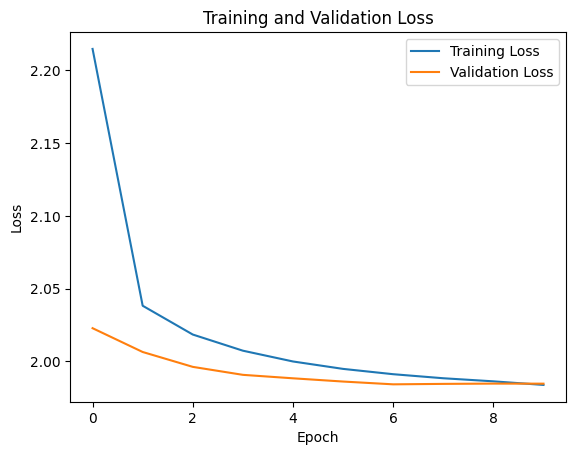

[2.2146573902625573, 2.0382529976119312, 2.0184749207737656, 2.007382700478352, 1.9999737590837388, 1.9948791696410566, 1.9912316653489, 1.9884528027691295, 1.9863329944287214, 1.983869307176928] [2.0228377878665924, 2.0064873434603214, 1.9962707497179508, 1.990795075893402, 1.9884143322706223, 1.9861884415149689, 1.984275195747614, 1.9845802336931229, 1.9847759939730167, 1.9847339428961277]


In [18]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print(train_losses, val_losses)

### Training WITH gradient accumulation

In [12]:
def train_epoch_acc(model, optimizer, trainloader, loss_fn, DEVICE, accum_iter=4):
    model.train()
    losses = 0
    optimizer.zero_grad()

    for batch_idx, (src, tgt) in enumerate(trainloader):
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
        
        # Compute the loss divided by accum_iter for gradient accumulation
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1)) / accum_iter
        loss.backward()

        if (batch_idx + 1) % accum_iter == 0 or (batch_idx + 1 == len(trainloader)):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional: Gradient clipping
            optimizer.step()
            optimizer.zero_grad()

        # Accumulate the actual (unscaled) loss for logging
        losses += loss.item() * accum_iter

    return losses / len(trainloader)

In [13]:
modelACC = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)

In [21]:
warnings.filterwarnings("ignore")

# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modelACC.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# Training configuration
NUM_EPOCHS = 15
train_losses = []
val_losses = []
counter = 0

best_epoch = 0
print_every = 3
best_val_loss = float('inf')

start_tot_time = timer()
# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    
    # Train for one epoch
    train_loss = train_epoch_acc(modelACC, optimizer, trainloader, loss_fn, DEVICE)    
    
    # Evaluate on validation data
    val_loss = evaluate(modelACC, valloader, loss_fn, DEVICE, N_HEAD)
    end_time = timer()

    if best_val_loss < val_loss:
        counter += 1
        if counter == 5:
            print(f'Overfitting at epoch {epoch}')
            break
    else:
        counter = 0
        best_val_loss = val_loss
        # save the best model
        torch.save({
                'epoch': epoch,
                'model_state_dict': modelACC.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'model_acc.pt')
        best_epoch = epoch

    # Log losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_tot_time = timer() - start_tot_time

    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"   Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")
        print(f"   Epoch time = {(end_time - start_time):.3f}s")
    
    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

print(f'Training time: {end_tot_time/60} minuti')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_losses[best_epoch-1]} and evaluation loss of {best_val_loss}")

Epoch: 3
   Train loss: 2.038, Val loss: 2.000
   Epoch time = 56.913s
Epoch: 6
   Train loss: 2.009, Val loss: 1.990
   Epoch time = 57.112s
Epoch: 9
   Train loss: 1.997, Val loss: 1.985
   Epoch time = 57.028s
Reached ten minutes of training without overfitting at epoch 11
Training time: 10.446434609499995 minuti
The best model is obtained at epoch 11 with a training loss of 1.9918870433964793 and evaluation loss of 1.9836101420223713


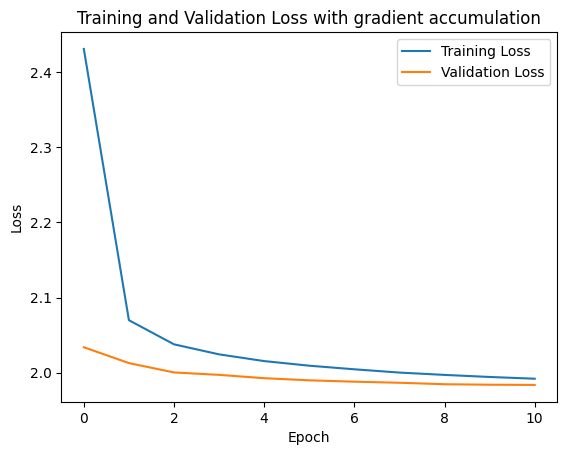

[2.4312413977417364, 2.069844666765961, 2.0376839479115705, 2.0243286029391006, 2.0153700074399046, 2.009215794537057, 2.004429233280116, 2.0000603022059797, 1.9969617874288283, 1.9941983148979974, 1.9918870433964793] [2.0338170900940895, 2.012715272605419, 2.000234667211771, 1.9970156252384186, 1.9925770945847034, 1.9897309057414532, 1.9879068583250046, 1.9865087494254112, 1.9845261052250862, 1.983883336186409, 1.9836101420223713]


In [22]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with gradient accumulation')
plt.legend()
plt.show()

print(train_losses, val_losses)

## Testing

Test your model on the test set and compare it with two baselines:

- random tour: Samples a random tour.
- greedy algorithm: Starts from a node and selects the closest unvisited
node iteratively.

In [14]:
model = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)
checkpoint = torch.load('/kaggle/input/tsp_models/pytorch/default/1/model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

modelACC = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)
checkpoint = torch.load('/kaggle/input/tsp_models/pytorch/default/1/model_acc.pt')
modelACC.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_23/1145661908.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/tsp_models/pytorch/default/1/model.pt')
/tmp/ipykerne

<All keys matched successfully>

In [24]:
graph, tour = test[0]
graph, tour

(<networkx.classes.graph.Graph at 0x7f4ee963f9d0>,
 [0, 4, 5, 9, 18, 15, 11, 10, 2, 8, 12, 3, 7, 6, 16, 1, 13, 19, 14, 17, 0])

In [15]:
# Lists to store gaps
gaps_random = []
gaps_greedy = []
gaps_model = []         # Model without gradient accumulation
gaps_model_ga = []      # Model with gradient accumulation

# Iterate over the test set
for G, _ in test:
    # Compute gaps
    gaps = gap(G, model, modelACC, device=DEVICE)

    # Store the gaps for each method
    gaps_random.append(gaps['random'])
    gaps_greedy.append(gaps['greedy'])
    gaps_model.append(gaps['transformer_tsp'])
    gaps_model_ga.append(gaps['transformer_tsp_acc_grad'])

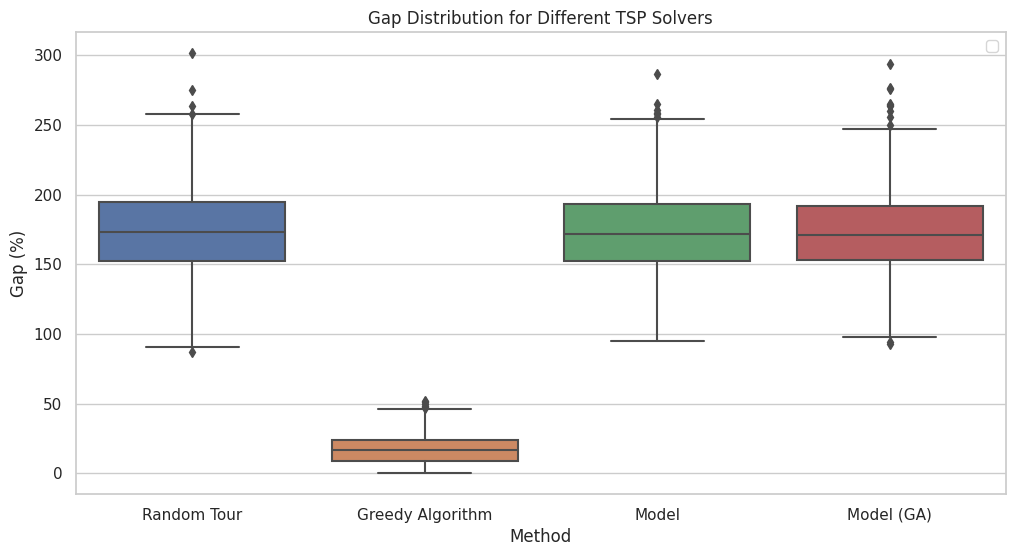

In [17]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Combine all gaps into a DataFrame for plotting
data = pd.DataFrame({
    'Random Tour': gaps_random,
    'Greedy Algorithm': gaps_greedy,
    'Model': gaps_model,
    'Model (GA)': gaps_model_ga
})

# Melt the DataFrame for seaborn boxplot
data_melted = data.melt(var_name='Method', value_name='Gap')

# Create boxplots
sns.boxplot(x='Method', y='Gap', data=data_melted)

# Add plot title and labels
plt.title('Gap Distribution for Different TSP Solvers')
plt.xlabel('Method')
plt.ylabel('Gap (%)')

# Show the plot
plt.show()